In [ ]:
import hexdump

path = "sch_data/my_sch_data"

with open(f"{path}/DESDOC.DAT", "rb") as f:
    data = f.read()

dump_str = hexdump.dump(data)

# Save it to a .txt file for inspection
with open(f"{path}/desdoc_dump.txt", "w") as out_file:
    out_file.write(dump_str)

print(f"Hexdump saved to {path}/desdoc_dump.txt")

In [ ]:
import os


def load_file(path):
    with open(path, "rb") as f:
        return f.read()


# ======== CONFIGURATION ========
file_path = "sch_data/cccc_sch_data/DESDOC.DAT"  # Update path if needed

# Load data
data = load_file(file_path)

# Markers for AAAA, BBBB, CCCC
marker_aaaa = b'\x41\x00\x41\x00\x41\x00\x41\x00'
marker_bbbb = b'\x42\x00\x42\x00\x42\x00\x42\x00'
marker_cccc = b'\x43\x00\x43\x00\x43\x00\x43\x00'

# Locate offsets
offset_aaaa = data.find(marker_aaaa)
offset_bbbb = data.find(marker_bbbb)
offset_cccc = data.find(marker_cccc)

# Report findings
print(f"AAAA offset: {hex(offset_aaaa) if offset_aaaa != -1 else 'Not Found'}")
print(f"BBBB offset: {hex(offset_bbbb) if offset_bbbb != -1 else 'Not Found'}")
print(f"CCCC offset: {hex(offset_cccc) if offset_cccc != -1 else 'Not Found'}")

# Check and compute block sizes
if offset_aaaa != -1 and offset_bbbb != -1:
    block_size1 = offset_bbbb - offset_aaaa
    print(f"Block size AAAA to BBBB: {block_size1} bytes")
else:
    print("Could not compute block size between AAAA and BBBB.")

if offset_bbbb != -1 and offset_cccc != -1:
    block_size2 = offset_cccc - offset_bbbb
    print(f"Block size BBBB to CCCC: {block_size2} bytes")
else:
    print("Could not compute block size between BBBB and CCCC.")

In [ ]:
import os


def load_file(path):
    with open(path, "rb") as f:
        return f.read()


def read_null_terminated_utf16_name(data, start_offset, max_bytes=64):
    """
    Reads a variable-length UTF-16LE string, stopping at null terminator or max_bytes.
    """
    name_bytes = bytearray()
    for i in range(0, max_bytes, 2):
        chunk = data[start_offset + i:start_offset + i + 2]
        if len(chunk) < 2 or chunk == b'\x00\x00':
            break
        name_bytes.extend(chunk)
    try:
        return name_bytes.decode('utf-16-le')
    except UnicodeDecodeError:
        return "<Invalid UTF-16 Encoding>"


# ======== CONFIGURATION ========
file_path = "sch_data/my_sch_data/DESDOC.DAT"

# Load data
data = load_file(file_path)

# Schematic count stored at byte 5
schematic_count = data[5]
print(f"Detected {schematic_count} schematic(s).\n")

# Find the first schematic marker offset
first_marker_offset = data.find(
    b'\x41\x00\x41\x00\x41\x00\x41\x00')  # AAAA marker

if first_marker_offset == -1:
    print("First schematic marker not found.")
else:
    print(f"First schematic marker found at {hex(first_marker_offset)}")

    # Set block size based on your earlier measurements
    BLOCK_SIZE = 24280

    print(f"Scanning {schematic_count} live schematic blocks...\n")

    # Iterate only live schematics
    for i in range(schematic_count):
        block_start = first_marker_offset + (i * BLOCK_SIZE)
        schematic_name = read_null_terminated_utf16_name(
            data, block_start, max_bytes=64)
        print(f"Block {i + 1} at offset {hex(block_start)}: {schematic_name}")

In [ ]:
import os


def load_file(path):
    with open(path, "rb") as f:
        return f.read()


def save_file(path, data):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "wb") as f:
        f.write(data)


def read_null_terminated_utf16_name(data, start_offset, max_bytes=64):
    name_bytes = bytearray()
    for i in range(0, max_bytes, 2):
        chunk = data[start_offset + i:start_offset + i + 2]
        if len(chunk) < 2 or chunk == b'\x00\x00':
            break
        name_bytes.extend(chunk)
    try:
        return name_bytes.decode('utf-16-le')
    except UnicodeDecodeError:
        return "<Invalid UTF-16 Encoding>"


def export_schematic(save_path, output_dir):
    data = load_file(save_path)
    schematic_count = data[5]
    print(f"Detected {schematic_count} schematic(s).")

    first_marker_offset = 0x149
    BLOCK_SIZE = 24280

    os.makedirs(output_dir, exist_ok=True)  # Ensure export directory exists

    for i in range(schematic_count):
        block_start = first_marker_offset + (i * BLOCK_SIZE)
        block_data = data[block_start:block_start + BLOCK_SIZE]
        name = read_null_terminated_utf16_name(
            block_data, 0, max_bytes=64).strip()
        safe_name = name if name else f"Slot{i+1}"
        file_name = f"{safe_name}_Slot{i+1}.acfa"
        save_file(os.path.join(output_dir, file_name), block_data)
        print(f"Exported {file_name}")


def import_schematic(save_path, acfa_path, slot_number):
    data = bytearray(load_file(save_path))
    schematic_data = load_file(acfa_path)

    first_marker_offset = 0x149
    BLOCK_SIZE = 24280

    target_offset = first_marker_offset + ((slot_number - 1) * BLOCK_SIZE)

    if len(schematic_data) != BLOCK_SIZE:
        print("❌ Invalid schematic file size.")
        return

    data[target_offset:target_offset + BLOCK_SIZE] = schematic_data
    save_file(save_path, data)
    print(f"✅ Inserted {os.path.basename(acfa_path)} into Slot {slot_number}")



In [ ]:
# Example Export:
#export_schematic("sch_data/aaaa_sch_data/DESDOC.DAT", "exports")

# Example Import:
import_schematic("sch_data/bbbb_sch_data/DESDOC.DAT",
                 "exports/AAAA_Slot1.acfa", 2)

In [ ]:
import os
import re


def load_file(path):
    with open(path, "rb") as f:
        return f.read()


def linear_utf16_clean_name_reader(data, start_offset, max_bytes=64):
    """
    Reads UTF-16LE and stops at the first non-alphanumeric sequence to remove residuals.
    """
    raw_field = data[start_offset:start_offset + max_bytes]
    try:
        decoded = raw_field.decode('utf-16-le', errors='ignore').strip('\x00')
        match = re.match(r'^[A-Za-z0-9 ]+', decoded)
        if match:
            return match.group(0).strip()
        return "<Invalid UTF-16 Encoding>"
    except UnicodeDecodeError:
        return "<Invalid UTF-16 Encoding>"


def is_block_empty(block):
    return all(b == 0 for b in block)


def list_schematic_names_smart(file_path, max_slots=200):
    data = load_file(file_path)
    first_marker_offset = 0x149
    BLOCK_SIZE = 24280

    print("Scanning for schematics...\n")
    slot_index = 0

    while True:
        block_start = first_marker_offset + (slot_index * BLOCK_SIZE)
        if block_start + BLOCK_SIZE > len(data):
            break

        block = data[block_start:block_start + BLOCK_SIZE]
        if is_block_empty(block):
            break

        schematic_name = linear_utf16_clean_name_reader(
            data, block_start, max_bytes=64)
        print(f"Slot {slot_index + 1} at {hex(block_start)}: {schematic_name}")

        slot_index += 1
        if slot_index >= max_slots:
            print("Reached max slot scan limit.")
            break


# Example Usage:
list_schematic_names_smart("sch_data/my_sch_data/DESDOC.DAT")

In [ ]:
import os
import binascii


def load_file(path):
    with open(path, "rb") as f:
        return f.read()


def dump_slot_hex(file_path, slot_indices, context_bytes=64):
    data = load_file(file_path)
    first_marker_offset = 0x149
    BLOCK_SIZE = 24280

    for slot_index in slot_indices:
        block_start = first_marker_offset + ((slot_index - 1) * BLOCK_SIZE)
        block = data[block_start:block_start + context_bytes]

        print(
            f"--- Slot {slot_index} at {hex(block_start)} (first {context_bytes} bytes) ---")
        print(binascii.hexlify(block).decode('ascii'))
        print()


# Example Usage:
# Dump slots 10, 11, and 13 from your save
dump_slot_hex("sch_data/my_sch_data/DESDOC.DAT",
              [10, 11, 13], context_bytes=128)

In [ ]:
import os
import binascii


def load_file(path):
    with open(path, "rb") as f:
        return f.read()


def dump_block(data, offset, block_size=24280, context_bytes=32):
    block = data[offset:offset + block_size]
    print(f"\n==== Dumping Block at {hex(offset)} ====")
    print(binascii.hexlify(block[:context_bytes]).decode('ascii') + " ...")
    return block


def compare_blocks(file_path, offset_a, offset_b, block_size=24280):
    data = load_file(file_path)
    block_a = data[offset_a:offset_a + block_size]
    block_b = data[offset_b:offset_b + block_size]

    if block_a == block_b:
        print("Blocks are IDENTICAL.")
    else:
        print("Blocks DIFFER. Dumping differences:")
        for i in range(min(len(block_a), len(block_b))):
            if block_a[i] != block_b[i]:
                print(
                    f"Offset {hex(i)}: {hex(block_a[i])} != {hex(block_b[i])}")


# Example Usage:
# Known offsets from earlier runs
OFFSET_KOMARIK = 0x4d241
OFFSET_KOMAR_1 = 0x5eec9
OFFSET_KOMAR_2 = 0x64da1

file_path = "sch_data/my_sch_data/DESDOC.DAT"

# Compare Komarik vs Komar 1
compare_blocks(file_path, OFFSET_KOMARIK, OFFSET_KOMAR_1)

# Optionally compare Komarik vs Komar 2
compare_blocks(file_path, OFFSET_KOMARIK, OFFSET_KOMAR_2)

In [ ]:
import os
import re


def load_file(path):
    with open(path, "rb") as f:
        return f.read()


def linear_utf16_clean_name_reader(data, start_offset, max_bytes=64):
    """
    Reads UTF-16LE and stops at the first non-alphanumeric sequence to remove residuals.
    """
    raw_field = data[start_offset:start_offset + max_bytes]
    try:
        decoded = raw_field.decode('utf-16-le', errors='ignore').strip('\x00')
        match = re.match(r'^[A-Za-z0-9 ]+', decoded)
        if match:
            return match.group(0).strip()
        return "<Invalid UTF-16 Encoding>"
    except UnicodeDecodeError:
        return "<Invalid UTF-16 Encoding>"


def is_block_empty(block):
    return all(b == 0 for b in block)


def is_marked_deleted(data, name_end_offset):
    """
    Checks if the two bytes immediately after the schematic name are 00 6E.
    """
    marker = data[name_end_offset:name_end_offset + 2]
    return marker == b'\x6E\x00'


def list_schematic_names_smart(file_path, max_slots=200):
    data = load_file(file_path)
    first_marker_offset = 0x149
    BLOCK_SIZE = 24280

    print("Scanning for schematics...\n")
    slot_index = 0

    while True:
        block_start = first_marker_offset + (slot_index * BLOCK_SIZE)
        if block_start + BLOCK_SIZE > len(data):
            break

        block = data[block_start:block_start + BLOCK_SIZE]
        if is_block_empty(block):
            break

        # Read schematic name and calculate its end offset
        raw_field = data[block_start:block_start + 64]
        try:
            null_index = raw_field.index(b'\x00\x00')
            name_bytes = raw_field[:null_index]
        except ValueError:
            name_bytes = raw_field

        name_end_offset = block_start + len(name_bytes)

        schematic_name = linear_utf16_clean_name_reader(
            data, block_start, max_bytes=64)

        deleted_flag = is_marked_deleted(data, name_end_offset)
        marker_bytes = data[name_end_offset:name_end_offset + 2].hex()
        status = "Deleted" if deleted_flag else "Active"

        print(
            f"Slot {slot_index + 1} at {hex(block_start)}: {schematic_name} ({status}, marker: {marker_bytes})")


        slot_index += 1
        if slot_index >= max_slots:
            print("Reached max slot scan limit.")
            break


# Example Usage:
list_schematic_names_smart("sch_data/my_sch_data/DESDOC.DAT")

In [ ]:
import os
import re


def load_file(path):
    with open(path, "rb") as f:
        return f.read()


def linear_utf16_clean_name_reader(data, start_offset, max_bytes=64):
    raw_field = data[start_offset:start_offset + max_bytes]
    try:
        decoded = raw_field.decode('utf-16-le', errors='ignore').strip('\x00')
        match = re.match(r'^[A-Za-z0-9 ]+', decoded)
        if match:
            return match.group(0).strip()
        return "<Invalid UTF-16 Encoding>"
    except UnicodeDecodeError:
        return "<Invalid UTF-16 Encoding>"


def is_block_empty(block):
    return all(b == 0 for b in block)


def detect_deletion_by_padding_and_marker(data, block_start, name_length_bytes):
    marker = data[block_start +
                  name_length_bytes:block_start + name_length_bytes + 4]
    if marker == b'\x00\x00\x6E\x00':
        trailing_data = data[block_start + name_length_bytes +
                             4:block_start + name_length_bytes + 64]
        if all(b == 0 for b in trailing_data):
            return True
    return False


def list_schematic_names_smart(file_path, max_slots=200):
    data = load_file(file_path)
    first_marker_offset = 0x149
    BLOCK_SIZE = 24280

    print("Scanning for schematics with deletion heuristic...\n")
    slot_index = 0

    while True:
        block_start = first_marker_offset + (slot_index * BLOCK_SIZE)
        if block_start + BLOCK_SIZE > len(data):
            break

        block = data[block_start:block_start + BLOCK_SIZE]
        if is_block_empty(block):
            break

        raw_field = data[block_start:block_start + 64]
        try:
            null_index = raw_field.index(b'\x00\x00')
            name_bytes = raw_field[:null_index]
        except ValueError:
            name_bytes = raw_field

        name_length_bytes = len(name_bytes)
        schematic_name = linear_utf16_clean_name_reader(
            data, block_start, max_bytes=64)

        is_deleted = detect_deletion_by_padding_and_marker(
            data, block_start, name_length_bytes)

        status = "Deleted" if is_deleted else "Active"
        print(
            f"Slot {slot_index + 1} at {hex(block_start)}: {schematic_name} ({status})")

        slot_index += 1
        if slot_index >= max_slots:
            print("Reached max slot scan limit.")
            break


# Example Usage:
list_schematic_names_smart("sch_data/del_sch_data/DESDOC.DAT")

In [ ]:
def dump_block_previews(file_path, count=5):
    data = load_file(file_path)
    first_marker_offset = 0x149
    BLOCK_SIZE = 24280

    for slot_index in range(count):
        block_start = first_marker_offset + (slot_index * BLOCK_SIZE)
        block = data[block_start:block_start + BLOCK_SIZE]
        print(
            f"Slot {slot_index + 1} at {hex(block_start)}: {linear_utf16_clean_name_reader(data, block_start)}")
        print(f"  Block preview: {' '.join(f'{b:02X}' for b in block[:64])}\n")


# Example Usage:
dump_block_previews("sch_data/del_sch_data/DESDOC.DAT")

In [ ]:
import os
import re


def load_file(path):
    with open(path, "rb") as f:
        return f.read()


def linear_utf16_clean_name_reader(data, start_offset, max_bytes=64):
    raw_field = data[start_offset:start_offset + max_bytes]
    try:
        decoded = raw_field.decode('utf-16-le', errors='ignore').strip('\x00')
        match = re.match(r'^[A-Za-z0-9 ]+', decoded)
        if match:
            return match.group(0).strip()
        return "<Invalid UTF-16 Encoding>"
    except UnicodeDecodeError:
        return "<Invalid UTF-16 Encoding>"


def dump_extended_block_previews(file_path, slot_count=5, preview_size=256):
    data = load_file(file_path)
    first_marker_offset = 0x149
    BLOCK_SIZE = 24280

    for slot_index in range(slot_count):
        block_start = first_marker_offset + (slot_index * BLOCK_SIZE)
        block = data[block_start:block_start + BLOCK_SIZE]
        schematic_name = linear_utf16_clean_name_reader(data, block_start)
        print(f"Slot {slot_index + 1} at {hex(block_start)}: {schematic_name}")
        print("  Extended preview:")
        preview_bytes = block[:preview_size]
        print('  ' + ' '.join(f'{b:02X}' for b in preview_bytes))
        print()


# Example Usage:
dump_extended_block_previews("sch_data/del_sch_data/DESDOC.DAT")

In [ ]:
def load_file(path):
    with open(path, "rb") as f:
        return f.read()


def extract_block(data, block_start, block_size=24280):
    return data[block_start:block_start + block_size]


def compare_blocks(label1, block1, label2, block2):
    print(f"\nComparing {label1} and {label2}:\n")
    length = min(len(block1), len(block2))
    differences_found = False

    for i in range(0, length, 16):
        b1_slice = block1[i:i+16]
        b2_slice = block2[i:i+16]

        hex_b1 = ' '.join(f'{b:02X}' for b in b1_slice)
        hex_b2 = ' '.join(f'{b:02X}' for b in b2_slice)

        diff_marker = ''.join(
            '  ' if b1_slice[j] == b2_slice[j] else '^^' for j in range(len(b1_slice)))

        if any(b1_slice[j] != b2_slice[j] for j in range(len(b1_slice))):
            differences_found = True

        print(f"{i:04X}: {hex_b1:<48} | {hex_b2:<48} | {diff_marker}")

    if not differences_found:
        print("\nNo differences found.\n")
    else:
        print("\nDifferences marked with ^^.\n")


# Example usage
file_path = "sch_data/del_sch_data/DESDOC.DAT"
data = load_file(file_path)

# Provide the start offsets of Slot 2 and Slot 4
slot2_start = 0x6021
slot4_start = 0x11dd1

block2 = extract_block(data, slot2_start)
block4 = extract_block(data, slot4_start)

compare_blocks("Slot 2 (Deleted)", block2, "Slot 4 (Deleted)", block4)

In [ ]:
import os


def load_file(path):
    with open(path, "rb") as f:
        return f.read()


def compare_blocks(file_path, offset1, offset2, block_size=24280, preview_size=256):
    data = load_file(file_path)

    block1 = data[offset1:offset1 + block_size][:preview_size]
    block2 = data[offset2:offset2 + block_size][:preview_size]

    print(f"\nComparing blocks at {hex(offset1)} and {hex(offset2)}:\n")
    for i in range(0, preview_size, 16):
        b1 = block1[i:i+16]
        b2 = block2[i:i+16]
        hex_b1 = ' '.join(f'{byte:02X}' for byte in b1)
        hex_b2 = ' '.join(f'{byte:02X}' for byte in b2)
        marker = '  ' + \
            ''.join('|' if j < len(b1) and b1[j] !=
                    b2[j] else ' ' for j in range(len(b1)))
        print(f'{i:04X}: {hex_b1:<47} | {hex_b2:<47}{marker}')


def main():
    file_path = "sch_data/del_sch_data/DESDOC.DAT"

    # Known slots (adjust these if your offsets change)
    active_1_offset = 0x149   # Slot 1 (Active)
    active_2_offset = 0xbef9  # Slot 3 (Active)

    deleted_1_offset = 0x6021  # Slot 2 (Deleted)
    deleted_2_offset = 0x11dd1  # Slot 4 (Deleted)

    # Active vs Active
    compare_blocks(file_path, active_1_offset, active_2_offset)

    # Deleted vs Deleted
    compare_blocks(file_path, deleted_1_offset, deleted_2_offset)

    # Active vs Deleted (first pair)
    compare_blocks(file_path, active_1_offset, deleted_1_offset)

    # Active vs Deleted (second pair)
    compare_blocks(file_path, active_2_offset, deleted_2_offset)


if __name__ == "__main__":
    main()

In [ ]:
def restore_schematic(file_path, src_offset, dest_offset, block_size=24280):
    data = bytearray(load_file(file_path))

    # Copy block from src_offset
    block_data = data[src_offset:src_offset + block_size]

    # Paste over dest_offset
    data[dest_offset:dest_offset + block_size] = block_data

    # Save to a new file
    restored_path = file_path + ".restored"
    with open(restored_path, "wb") as f:
        f.write(data)

    print(
        f"Restored block from {hex(src_offset)} to {hex(dest_offset)} in {restored_path}")
    

restore_schematic("sch_data/del_sch_data/DESDOC.DAT", 0x149, 0x6021)

In [ ]:
def patch_metadata(file_path, source_offset, target_offset, metadata_offset_in_block, length=8):
    data = bytearray(load_file(file_path))

    # Compute absolute positions
    src_pos = source_offset + metadata_offset_in_block
    dst_pos = target_offset + metadata_offset_in_block

    # Copy metadata
    metadata = data[src_pos:src_pos + length]
    data[dst_pos:dst_pos + length] = metadata

    # Save to a new file
    patched_path = file_path + ".patched"
    with open(patched_path, "wb") as f:
        f.write(data)

    print(
        f"Patched {length} bytes from {hex(src_pos)} to {hex(dst_pos)} in {patched_path}")


patch_metadata("sch_data/del_sch_data/DESDOC.DAT", 0x149, 0x6021, 0x00C0)

In [ ]:
import os
import re


def load_file(path):
    with open(path, "rb") as f:
        return f.read()


def linear_utf16_clean_name_reader(data, start_offset, max_bytes=64):
    raw_field = data[start_offset:start_offset + max_bytes]
    try:
        decoded = raw_field.decode('utf-16-le', errors='ignore').strip('\x00')
        match = re.match(r'^[A-Za-z0-9 ]+', decoded)
        if match:
            return match.group(0).strip()
        return "<Invalid UTF-16 Encoding>"
    except UnicodeDecodeError:
        return "<Invalid UTF-16 Encoding>"


def is_block_empty(block):
    return all(b == 0 for b in block)


def list_active_schematic_names_and_designers(file_path):
    data = load_file(file_path)
    schematic_count = data[5]
    print(f"Detected {schematic_count} active schematic(s).\n")

    first_marker_offset = 0x149
    BLOCK_SIZE = 24280
    NAME_SIZE = 96  # 48 wchar_t = 96 bytes

    for slot_index in range(schematic_count):
        block_start = first_marker_offset + (slot_index * BLOCK_SIZE)

        name_offset = block_start
        designer_offset = block_start + NAME_SIZE

        schematic_name = linear_utf16_clean_name_reader(
            data, name_offset, max_bytes=NAME_SIZE)
        designer_name = linear_utf16_clean_name_reader(
            data, designer_offset, max_bytes=NAME_SIZE)

        print(
            f"Slot {slot_index + 1} at {hex(block_start)}: {schematic_name} by {designer_name}")

In [ ]:
list_active_schematic_names_and_designers("sch_data/my_sch_data/DESDOC.DAT")

In [ ]:
import os
import re
import struct


def load_file(path):
    with open(path, "rb") as f:
        return f.read()


def linear_utf16_clean_name_reader(data, start_offset, max_bytes=96):
    raw_field = data[start_offset:start_offset + max_bytes]
    try:
        decoded = raw_field.decode('utf-16-le', errors='ignore').strip('\x00')
        match = re.match(r'^[A-Za-z0-9 ]+', decoded)
        if match:
            return match.group(0).strip()
        return "<Invalid UTF-16 Encoding>"
    except UnicodeDecodeError:
        return "<Invalid UTF-16 Encoding>"


def read_timestamp(data, offset):
    # Timestamp is an 8-byte unsigned integer
    timestamp_bytes = data[offset:offset + 8]
    # Big-endian unsigned long long
    return struct.unpack(">Q", timestamp_bytes)[0]


def list_active_schematics(file_path):
    data = load_file(file_path)
    schematic_count = data[5]
    print(f"Detected {schematic_count} active schematic(s).\n")

    first_marker_offset = 0x148  # Corrected offset
    BLOCK_SIZE = 24280

    for slot_index in range(schematic_count):
        block_start = first_marker_offset + (slot_index * BLOCK_SIZE)

        # Read schematic name and designer name (each 96 bytes = 48 wchar_t = 96 bytes in UTF-16)
        name_offset = block_start
        designer_offset = block_start + 96
        timestamp_offset = block_start + 192  # 96 + 96

        schematic_name = linear_utf16_clean_name_reader(
            data, name_offset + 1, max_bytes=96)
        designer_name = linear_utf16_clean_name_reader(
            data, designer_offset + 1, max_bytes=96)
        timestamp = read_timestamp(data, timestamp_offset)

        # Category/protect byte follows timestamp (at offset +8)
        protect_category_byte_offset = timestamp_offset + 8
        protect_category_byte = data[protect_category_byte_offset]
        protect = (protect_category_byte & 0b10000000) >> 7
        category = (protect_category_byte & 0b01111111) + \
            1  # Adjusted to match User 01-based display

        print(f"Slot {slot_index + 1} at {hex(block_start)}:")
        print(f"  Name: {schematic_name}")
        print(f"  Designer: {designer_name}")
        print(f"  Protect: {protect}")
        print(f"  User Slot: {category}")
        print(f"  Raw Byte: 0x{protect_category_byte:02x}")
        print(f"  Timestamp: {timestamp}")
        print()

# Example Usage:
list_active_schematics("sch_data/my_sch_data/DESDOC.DAT")

In [ ]:
import os
import re


def load_file(path):
    with open(path, "rb") as f:
        return f.read()


def linear_utf16_clean_name_reader(data, start_offset, max_bytes=64):
    raw_field = data[start_offset:start_offset + max_bytes]
    try:
        decoded = raw_field.decode('utf-16-le', errors='ignore').strip('\x00')
        match = re.match(r'^[A-Za-z0-9 _-]+', decoded)
        if match:
            return match.group(0).strip()
        return "<Invalid UTF-16 Encoding>"
    except UnicodeDecodeError:
        return "<Invalid UTF-16 Encoding>"


def extract_schematic_by_slot(file_path, slot_number, output_folder="exports"):
    data = load_file(file_path)
    schematic_count = data[5]

    if not (1 <= slot_number <= schematic_count):
        print(f"Invalid slot number. Valid range is 1 to {schematic_count}.")
        return

    first_marker_offset = 0x149
    BLOCK_SIZE = 24280
    NAME_SIZE = 96  # 48 wchar_t = 96 bytes

    block_start = first_marker_offset + (slot_number - 1) * BLOCK_SIZE

    schematic_name = linear_utf16_clean_name_reader(
        data, block_start, NAME_SIZE)
    designer_name = linear_utf16_clean_name_reader(
        data, block_start + NAME_SIZE, NAME_SIZE)

    # Sanitize file name
    safe_schematic_name = re.sub(
        r'[^A-Za-z0-9 _-]', '', schematic_name) or "Unknown"
    safe_designer_name = re.sub(
        r'[^A-Za-z0-9 _-]', '', designer_name) or "Unknown"
    filename = f"{safe_schematic_name}-{safe_designer_name}.ac4a"

    # Prepare output directory
    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, filename)

    # Write the block to file
    with open(output_path, "wb") as f:
        f.write(data[block_start:block_start + BLOCK_SIZE])

    print(f"Schematic in slot {slot_number} extracted to: {output_path}")

# Example usage:


In [ ]:
extract_schematic_by_slot("sch_data/my_sch_data/DESDOC.DAT", 6)

In [ ]:
import os


def load_file(path):
    with open(path, "rb") as f:
        return f.read()


def save_file(path, data):
    with open(path, "wb") as f:
        f.write(data)


def insert_schematic(ac4a_path, desdoc_path):
    ac4a_data = load_file(ac4a_path)
    desdoc_data = bytearray(load_file(desdoc_path))

    BLOCK_SIZE = 24280
    schematic_count_offset = 5  # The byte that holds the active schematic count
    first_marker_offset = 0x149

    active_schematic_count = desdoc_data[schematic_count_offset]
    print(f"Current active schematic count: {active_schematic_count}")

    insertion_offset = first_marker_offset + \
        (active_schematic_count * BLOCK_SIZE)

    # Ensure the insertion is within bounds
    if insertion_offset + BLOCK_SIZE > len(desdoc_data):
        print("Error: Not enough space to insert schematic.")
        return

    # Insert schematic data
    desdoc_data[insertion_offset:insertion_offset +
                BLOCK_SIZE] = ac4a_data[:BLOCK_SIZE]

    # Increment schematic count
    desdoc_data[schematic_count_offset] += 1
    print(
        f"New schematic inserted at slot {active_schematic_count + 1} (offset {hex(insertion_offset)}). New count: {desdoc_data[schematic_count_offset]}")

    # Write the modified file
    save_file(desdoc_path, desdoc_data)



In [ ]:
# Example Usage:
insert_schematic("exports/Sbeu Komarik-Vlabus.ac4a", "sch_data/aaaa_sch_data/DESDOC.DAT")

In [1]:
import os
import re
import struct

BLOCK_SIZE = 24280
NAME_SIZE = 96  # 48 wchar_t = 96 bytes in UTF-16


def load_file(path):
    with open(path, "rb") as f:
        return f.read()


def linear_utf16_clean_name_reader(data, start_offset, max_bytes=96):
    raw_field = data[start_offset:start_offset + max_bytes]
    try:
        decoded = raw_field.decode('utf-16-le', errors='ignore').strip('\x00')
        match = re.match(r'^[A-Za-z0-9 ]+', decoded)
        if match:
            return match.group(0).strip()
        return "<Invalid UTF-16 Encoding>"
    except UnicodeDecodeError:
        return "<Invalid UTF-16 Encoding>"


def read_timestamp(data, offset):
    timestamp_bytes = data[offset:offset + 8]
    return struct.unpack(">Q", timestamp_bytes)[0]


def extract_active_schematic_blocks(file_path):
    data = load_file(file_path)
    schematic_count = data[5]
    blocks = []
    first_marker_offset = 0x148

    for slot_index in range(schematic_count):
        block_start = first_marker_offset + (slot_index * BLOCK_SIZE)
        block = data[block_start:block_start + BLOCK_SIZE]
        blocks.append(block)
    return blocks


def display_schematic_info(block):
    schematic_name = linear_utf16_clean_name_reader(block, 1, NAME_SIZE)
    designer_name = linear_utf16_clean_name_reader(
        block, 1 + NAME_SIZE, NAME_SIZE)
    timestamp = read_timestamp(block, 192)

    protect_category_byte = block[200]
    protect = (protect_category_byte & 0b10000000) >> 7
    category = (protect_category_byte & 0b01111111) + 1

    parts = extract_parts(block)
    tuning = extract_tuning(block)

    schematic_info = {
        "name": schematic_name,
        "designer": designer_name,
        "protect": protect,
        "category": category,
        "raw_byte": protect_category_byte,
        "timestamp": timestamp,
        "parts": parts,
        "tuning": tuning
    }

    # Optional print for debugging
    print(f"  Name: {schematic_info['name']}")
    print(f"  Designer: {schematic_info['designer']}")
    print(f"  Protect: {schematic_info['protect']}")
    print(f"  User Slot: {schematic_info['category']}")
    print(f"  Raw Byte: 0x{schematic_info['raw_byte']:02x}")
    print(f"  Timestamp: {schematic_info['timestamp']}")
    print("  Parts:", schematic_info['parts'])
    print("  Tuning:", schematic_info['tuning'])
    print()

    return schematic_info


def extract_parts(block):
    # Placeholder: parts data starts after 0xC9 (201) + 15 + 40 (Parts structure start)
    parts_offset = 201 + 15
    # Assuming Parts block is 76 bytes long based on field sizes (38 ushorts * 2)
    parts_block = block[parts_offset:parts_offset + 76]
    return ["<Part ID List Placeholder>"]  # Replace later


def extract_tuning(block):
    # Placeholder: tuning data starts after parts (201 + 15 + 76)
    tuning_offset = 201 + 15 + 76
    tuning_block = block[tuning_offset:tuning_offset + 32]  # 32 tuning bytes
    return ["<Tuning Values Placeholder>"]  # Replace later


# Example usage:
file_path = "sch_data/my_sch_data/DESDOC.DAT"
blocks = extract_active_schematic_blocks(file_path)
print(f"Detected {len(blocks)} active schematic(s).\n")

for idx, block in enumerate(blocks, 1):
    print(f"Slot {idx}:")
    display_schematic_info(block)

Detected 8 active schematic(s).

Slot 1:
  Name: AAAA
  Designer: Vlabus
  Protect: 0
  User Slot: 1
  Raw Byte: 0x00
  Timestamp: 63882918406832434
  Parts: ['<Part ID List Placeholder>']
  Tuning: ['<Tuning Values Placeholder>']

Slot 2:
  Name: Bomber
  Designer: Inveigh
  Protect: 0
  User Slot: 1
  Raw Byte: 0x00
  Timestamp: 63861092783094213
  Parts: ['<Part ID List Placeholder>']
  Tuning: ['<Tuning Values Placeholder>']

Slot 3:
  Name: Sniper
  Designer: Inveigh
  Protect: 0
  User Slot: 1
  Raw Byte: 0x00
  Timestamp: 63856408134194256
  Parts: ['<Part ID List Placeholder>']
  Tuning: ['<Tuning Values Placeholder>']

Slot 4:
  Name: BEZELTANK
  Designer: BEZEL
  Protect: 0
  User Slot: 1
  Raw Byte: 0x00
  Timestamp: 63856408697989959
  Parts: ['<Part ID List Placeholder>']
  Tuning: ['<Tuning Values Placeholder>']

Slot 5:
  Name: Sbeu Shmel
  Designer: Vlabus
  Protect: 0
  User Slot: 2
  Raw Byte: 0x01
  Timestamp: 63882961789730868
  Parts: ['<Part ID List Placeholder>']

In [4]:
import os


def save_schematic_block_as_ac4a(hex_block: bytes):
    """
    Saves a single schematic block to a .ac4a file.
    Example output_path: 'output/my_schematic.ac4a'
    """
    sch_data = display_schematic_info(hex_block)
    schematic_name = sch_data['name']
    designer_name = sch_data['designer']
    output_path = f"output/{schematic_name}_{designer_name}.ac4a"

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, "wb") as f:
        f.write(hex_block)


def load_schematic_block_from_ac4a(file_path: str) -> bytes:
    """
    Loads a schematic block from a .ac4a file.
    Returns the raw bytes representing the schematic block.
    """
    with open(file_path, "rb") as f:
        return f.read()

In [6]:
# Save block 1 to .ac4a file
save_schematic_block_as_ac4a(blocks[7])

# Load it back
loaded_block = load_schematic_block_from_ac4a("output/Sbeu SBIH_Vlabius.ac4a")

# Verify loaded block content by displaying its information
display_schematic_info(loaded_block)

  Name: Sbeu SBIH
  Designer: Vlabius
  Protect: 0
  User Slot: 3
  Raw Byte: 0x02
  Timestamp: 63882158259055003
  Parts: ['<Part ID List Placeholder>']
  Tuning: ['<Tuning Values Placeholder>']

  Name: Sbeu SBIH
  Designer: Vlabius
  Protect: 0
  User Slot: 3
  Raw Byte: 0x02
  Timestamp: 63882158259055003
  Parts: ['<Part ID List Placeholder>']
  Tuning: ['<Tuning Values Placeholder>']



{'name': 'Sbeu SBIH',
 'designer': 'Vlabius',
 'protect': 0,
 'category': 3,
 'raw_byte': 2,
 'timestamp': 63882158259055003,
 'parts': ['<Part ID List Placeholder>'],
 'tuning': ['<Tuning Values Placeholder>']}

In [9]:
def parse_part_mapping(file_path):
    part_mapping = {}
    current_category = None

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue  # Skip empty lines

            # Detect category header like 'Head (0):'
            if line.endswith('):'):
                category_name, category_id = line[:-2].rsplit('(', 1)
                current_category = category_name.strip()
                part_mapping[current_category] = {}
                continue

            if current_category is None:
                continue  # Skip any lines before first category

            # Split the line into part_id and part_name
            if ' ' in line:
                part_id, part_name = line.split(' ', 1)
                part_mapping[current_category][part_id.strip()
                                               ] = part_name.strip()

    return part_mapping


# Example usage
part_mapping = parse_part_mapping("ACFA_PS3_US_PARTID_TO_PARTNAME.txt")

# Example: print all head parts
for part_id, part_name in part_mapping.get('Arms', {}).items():
    print(f"{part_id}: {part_name}")

0010: GAN01-SS-AL
0041: GAN02-NSS-A
3010: 047AN03
3021: 063AN03
4010: A01-TELLUS
1010: AM-HOGIRE
1031: AM-LANCEL
5031: EKHAZAR-ARMS
2010: 03-AALIYAH/A
7011: WHITE-GLINT/ARMS
4041: A11-LATONA
1020: AM-JUDITH
1041: AM-LAHIRE
5010: SOLUH-ARMS
6011: XAM-SOBRERO
2020: LINSTANT/A
0020: GAN01-SS-A
4020: HILBERT-G7A
4061: SOLDNER-G8A
0051: ARGYROS/A
0030: GAN01-SS-AW
0071: RAIDEN-AW
5120: SAUTEES-ARMS
5041: EKLAKH-ARMS
4051: A12-OPS
0061: ARGYROS/XA
2130: MADNESS/XA
4030: A06-AURORA
9000: AM-LANCEL
9010: 047AN03
9121: 45_Aspina


In [14]:
heads = part_mapping.get('Main Booster', {})
print(heads)
print(heads.get('3010'))
print(part_mapping)

{'0010': 'GAN01-SS-ML.CG', '0031': 'GAN02-NSS-M.CG', '1020': 'CB-HOGIRE', '5011': 'EKHAZAR-CORB', '5021': 'DUSKAROR-CORB', '2020': '03-AALIYAH/M', '2010': 'S04-VIRTUE', '4021': 'MB11-LATONA', '1010': 'CB-RACHEL', '1030': 'CB-JUDITH', '1041': 'CB-LAHIRE', '0020': 'GAN01-SS-M.CG', '4010': 'MB107-POLARIS', '0041': 'ARGYROS/M', '9000': 'CB-RACHEL', '9010': 'CB-RACHEL'}
None
{'Head': {'0031': 'GAN02-NSS-H', '3010': '047AN02', '3021': '063AN02', '4010': 'H01-TELLUS', '1010': 'HD-HOGIRE', '1041': 'HD-LANCEL', '5021': 'EKHAZAR-HEAD', '2010': '03-AALIYAH/H', '7011': 'WHITE-GLINT/HEAD', '4031': 'H11-LATONA', '1020': 'HD-JUDITH', '1030': 'HD-HOLOFERNES', '1051': 'HD-LAHIRE', '5010': 'SOLUH-HEAD', '6011': 'XHD-SOBRERO', '2020': 'LINSTANT/H', '0010': 'GAN01-SS-H', '0020': 'KIRITUMI-H', '4020': 'HILBERT-G7H', '4041': 'SOLDNER-G8H', '0041': 'ARGYROS/H', '9000': 'HD-LANCEL', '9010': '047AN02', '9300': '063AN02'}, 'Core': {'0021': 'GAN02-NSS-C', '3010': '047AN01', '3021': '063AN01', '4010': 'C01-TELLUS

# AC4 testing

In [1]:
import os
import sys
import re
import shutil
import struct

BLOCK_SIZE = 24280
NAME_SIZE = 96


def resource_path(relative_path):
    """
    Get the absolute path to a resource, works for dev and PyInstaller bundles.
    """
    if hasattr(sys, "_MEIPASS"):
        return os.path.join(sys._MEIPASS, relative_path)
    return os.path.join(os.path.abspath("."), relative_path)


def parse_part_mapping(file_path):
    file_path = resource_path(file_path)

    part_mapping = {}
    current_category = None
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            if line.endswith('):'):
                category_name, _ = line[:-2].rsplit('(', 1)
                current_category = category_name.strip()
                part_mapping[current_category] = {}
                continue
            if current_category and ' ' in line:
                part_id, part_name = line.split(' ', 1)
                part_mapping[current_category][part_id.strip()
                                               ] = part_name.strip()
    return part_mapping


def load_file(path):
    with open(path, "rb") as f:
        return f.read()


def save_file(path, data):
    with open(path, "wb") as f:
        f.write(data)


def backup_desdoc(desdoc_path):
    """
    Creates a backup of the DESDOC.DAT file.
    If desdoc.bak already exists, it appends a counter: desdoc.bak1, desdoc.bak2, etc.
    """
    base_path = desdoc_path
    counter = 0
    while True:
        suffix = f".bak{counter}" if counter else ".bak"
        backup_path = base_path + suffix
        if not os.path.exists(backup_path):
            shutil.copy2(desdoc_path, backup_path)
            print(f"Backup created: {backup_path}")
            break
        counter += 1

    return f'Backup created: {backup_path}'


def linear_utf16_clean_name_reader(data, start_offset, max_bytes=96):
    raw_field = data[start_offset:start_offset + max_bytes]
    try:
        decoded = raw_field.decode('utf-16-le', errors='ignore').strip('\x00')
        match = re.match(r'^[A-Za-z0-9 ]+', decoded)
        return match.group(0).strip() if match else "<Invalid UTF-16 Encoding>"
    except UnicodeDecodeError:
        return "<Invalid UTF-16 Encoding>"


def read_timestamp(data, offset):
    timestamp_bytes = data[offset:offset + 8]
    return struct.unpack(">Q", timestamp_bytes)[0]


def extract_active_schematic_blocks(file_path):
    data = load_file(file_path)
    schematic_count = data[5]
    first_marker_offset = 0x148
    return [data[first_marker_offset + i * BLOCK_SIZE:first_marker_offset + (i + 1) * BLOCK_SIZE]
            for i in range(schematic_count)]


def display_schematic_info(block, part_mapping):
    schematic_name = linear_utf16_clean_name_reader(block, 1, NAME_SIZE)
    designer_name = linear_utf16_clean_name_reader(
        block, 1 + NAME_SIZE, NAME_SIZE)
    timestamp = read_timestamp(block, 192)
    protect_category_byte = block[200]
    category = (protect_category_byte & 0b01111111) + 1
    parts = extract_parts(block, part_mapping)
    tuning = extract_tuning(block)

    return {
        "name": schematic_name,
        "designer": designer_name,
        "category": category,
        "timestamp": timestamp,
        "parts": parts,
        "tuning": tuning
    }


def extract_parts(block, part_name_lookup):
    LOCAL_PARTS_OFFSET = 0xD8
    PART_ENTRY_SIZE = 2
    lookup_keys = [
        'Head', 'Core', 'Arms', 'Legs', 'FCS', 'Generator', 'Main Booster',
        'Back Booster', 'Side Booster', 'Overed Booster',
        'Arm Unit', 'Arm Unit', 'Back Unit', 'Back Unit', 'Shoulder Unit'
    ]
    display_labels = [
        'Head', 'Core', 'Arms', 'Legs', 'FCS', 'Generator', 'Main Booster',
        'Back Booster', 'Side Booster', 'Overed Booster',
        'Right Arm Unit', 'Left Arm Unit', 'Right Back Unit', 'Left Back Unit', 'Shoulder Unit'
    ]

    parts_info = []
    for i, (lookup_key, display_label) in enumerate(zip(lookup_keys, display_labels)):
        offset = LOCAL_PARTS_OFFSET + i * PART_ENTRY_SIZE
        part_id_bytes = block[offset:offset + PART_ENTRY_SIZE]
        if len(part_id_bytes) == 2:
            part_id_num = int.from_bytes(part_id_bytes, byteorder='big')
            part_id_str = f"{part_id_num:04d}"
            part_name = part_name_lookup.get(lookup_key, {}).get(
                part_id_str, f"Unknown ID {part_id_str}")
        else:
            part_id_str = "<Invalid>"
            part_name = "<Invalid>"
        parts_info.append({"category": display_label,
                          "part_id": part_id_str, "part_name": part_name})
    return parts_info


def extract_tuning(block):
    LOCAL_TUNING_OFFSET = 0x126
    tuning_labels = [
        'en_output', 'en_capacity', 'kp_output', 'load', 'en_weapon_skill',
        'maneuverability', 'firing_stability', 'aim_precision', 'lock_speed', 'missile_lock_speed',
        'radar_refresh_rate', 'ecm_resistance', 'rectification_head', 'rectification_core',
        'rectification_arm', 'rectification_leg', 'horizontal_thrust_main', 'vertical_thrust',
        'horizontal_thrust_side', 'horizontal_thrust_back', 'quick_boost_main', 'quick_boost_side',
        'quick_boost_back', 'quick_boost_overed', 'turning_ability', 'stability_head',
        'stability_core', 'stability_legs'
    ]
    return {label: block[LOCAL_TUNING_OFFSET + i] for i, label in enumerate(tuning_labels)}


def save_schematic_block_as_ac4a(hex_block: bytes, part_mapping: dict, output_dir="output"):
    info = display_schematic_info(hex_block, part_mapping)
    filename = f"{info['name']}_{info['designer']}.ac4a"
    os.makedirs(output_dir, exist_ok=True)
    save_file(os.path.join(output_dir, filename), hex_block)


def load_schematic_block_from_ac4a(file_path):
    return load_file(file_path)


def insert_schematic(ac4a_path, desdoc_path):
    backup_msg = backup_desdoc(desdoc_path)
    ac4a_data = load_file(ac4a_path)
    desdoc_data = bytearray(load_file(desdoc_path))
    current_count = desdoc_data[5]
    insertion_offset = 0x148 + (current_count * BLOCK_SIZE)

    if insertion_offset + BLOCK_SIZE > len(desdoc_data):
        raise ValueError("Not enough space to insert schematic.")

    desdoc_data[insertion_offset:insertion_offset +
                BLOCK_SIZE] = ac4a_data[:BLOCK_SIZE]
    desdoc_data[5] += 1
    save_file(desdoc_path, desdoc_data)
    return f"Inserted schematic from {ac4a_path} into {desdoc_path}. {backup_msg}"

In [2]:
def extract_thumbnail_bytes(block: bytes) -> bytes:
    LOCAL_THUMBNAIL_OFFSET = 0x1EC4
    THUMBNAIL_TOTAL_SIZE = 0x4010  # Includes 0x10-byte header + 0x4000 data

    if len(block) < LOCAL_THUMBNAIL_OFFSET + THUMBNAIL_TOTAL_SIZE:
        raise ValueError("Block too small to contain thumbnail")

    return block[LOCAL_THUMBNAIL_OFFSET:LOCAL_THUMBNAIL_OFFSET + THUMBNAIL_TOTAL_SIZE]

In [25]:
blocks = extract_active_schematic_blocks("sch_data/my_sch_data/DESDOC.DAT")
thumbnail_bytes = extract_thumbnail_bytes(blocks[2])
with open("output/thumb3.bin", "wb") as f:
    f.write(thumbnail_bytes)

print("Extracted thumbnail bytes:", ' '.join(f"{b:02x}" for b in thumbnail_bytes))

Extracted thumbnail bytes: 01 00 00 80 00 00 00 00 00 00 00 00 00 00 40 00 8e 83 00 00 ff a1 f1 f1 14 a5 e3 18 55 bf 35 0d 14 a5 49 4a 01 00 a0 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 55 00 14 a5 ef 7b aa 00 05 00 14 a5 51 8c aa 00 40 00 14 a5 51 8c aa 00 55 00 14 a5 51 8c aa 00 55 00 14 a5 51 8c aa 00 55 00 14 a5 51 8c aa 00 55 00 14 a5 51 8c aa 00 55 00 14 a5 51 8c aa 00 55 00 8e 73 14 a5 55 55 4a 45 14 a5 d3 9c 55 aa 00 aa 14 a5 d3 9c 55 aa 00 aa 14 a5 d3 9c 55 aa 00 aa 14 a5 d3 9c 55 aa 00 aa 14 a5 d3 9c 5

In [34]:
def save_dds_thumbnail(data: bytes, output_path="output_thumbnail.dds"):
    """
    Saves a raw 128x128 DXT1 compressed ACFA thumbnail as a .dds file.
    Expects 16KB (16384 bytes) of raw DXT1 data (after the 16-byte header).
    """
    if len(data) != 16384:
        raise ValueError(
            "Thumbnail data must be exactly 16KB for DXT1 @ 128x128.")

    # DDS header for 128x128 DXT1 image
    def dds_header(width, height, size, fourcc=b'DXT1'):
        return b''.join([
            b'DDS ',                     # Magic number
            (124).to_bytes(4, 'little'),  # Size of DDS_HEADER
            (0x00021007).to_bytes(4, 'little'),  # Flags
            height.to_bytes(4, 'little'),
            width.to_bytes(4, 'little'),
            size.to_bytes(4, 'little'),  # PitchOrLinearSize
            (0).to_bytes(4, 'little'),   # Depth
            (0).to_bytes(4, 'little'),   # MipMapCount
            b'\x00' * 44,                # Reserved
            (32).to_bytes(4, 'little'),  # Size of DDS_PIXELFORMAT
            (0x00000004).to_bytes(4, 'little'),  # Flags: DDPF_FOURCC
            fourcc,                     # FourCC
            (0).to_bytes(4, 'little') * 5,  # RGBBitCount + masks
            (0x00001000).to_bytes(4, 'little'),  # Caps1
            (0).to_bytes(4, 'little') * 3       # Caps2 + Reserved
        ])

    header = dds_header(128, 128, size=len(data))
    with open(output_path, "wb") as f:
        f.write(header)
        f.write(data)

    print(f"DDS thumbnail saved to: {output_path}")

In [35]:
save_dds_thumbnail(thumbnail_bytes[0x10:], "output/thumb_test.dds")

DDS thumbnail saved to: output/thumb_test.dds


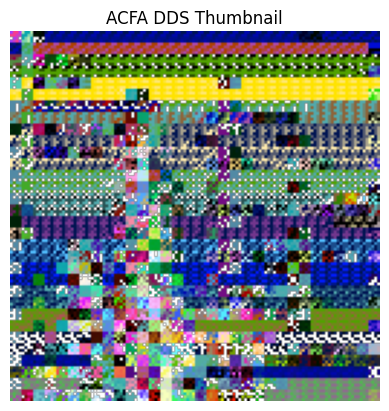

In [36]:
import imageio.v3 as iio
import matplotlib.pyplot as plt


def show_dds_image(path):
    image = iio.imread(path)
    plt.imshow(image)
    plt.axis('off')
    plt.title("ACFA DDS Thumbnail")
    plt.show()


# Example usage:
show_dds_image("output/thumb_test.dds")

In [37]:
from pathlib import Path


def extract_ac4_schematic_blocks(file_path: str, block_size: int = 0x1EB0, design_capacity: int = 128) -> list[bytes]:
    """
    Extracts schematic blocks from an Armored Core 4 DESDOC.DAT file.

    Args:
        file_path (str): Path to the DESDOC.DAT file.
        block_size (int): Size of each schematic block (default 0x1EB0 for AC4 US version).
        design_capacity (int): Maximum number of schematic slots (typically 128).

    Returns:
        list[bytes]: List of raw bytes, one for each design.
    """
    with open(file_path, "rb") as f:
        data = f.read()

    design_count = int.from_bytes(data[0:2], byteorder="big")
    print(f"Detected {design_count} saved schematics.")

    blocks = []
    base_offset = 4  # First 4 bytes are header (design count + unk02)

    for i in range(min(design_count, design_capacity)):
        start = base_offset + i * block_size
        end = start + block_size
        blocks.append(data[start:end])

    return blocks

In [38]:
blocks = extract_ac4_schematic_blocks("sch_data/ac4/DESDOC.DAT")
print(f"Extracted {len(blocks)} schematics.")

Detected 5 saved schematics.
Extracted 5 schematics.


In [45]:
NAME_SIZE = 96


def linear_utf16_clean_name_reader(data, start_offset, max_bytes=96):
    raw_field = data[start_offset:start_offset + max_bytes]
    try:
        decoded = raw_field.decode('utf-16-le', errors='ignore').strip('\x00')
        match = re.match(r'^[A-Za-z0-9 _\-.]+', decoded)
        return match.group(0).strip() if match else "<Invalid UTF-16 Encoding>"
    except UnicodeDecodeError:
        return "<Invalid UTF-16 Encoding>"

def display_schematic_info(block):
    schematic_name = linear_utf16_clean_name_reader(block, 1, NAME_SIZE)
    designer_name = linear_utf16_clean_name_reader(
        block, 1 + NAME_SIZE, NAME_SIZE)
    #timestamp = read_timestamp(block, 192)
    #protect_category_byte = block[200]
    #category = (protect_category_byte & 0b01111111) + 1
    #parts = extract_parts(block, part_mapping)
    #tuning = extract_tuning(block)

    return {
        "name": schematic_name,
        "designer": designer_name,
    }

In [46]:
print("Schematic Names and Designers:")
for idx, block in enumerate(blocks, 1):
    info = display_schematic_info(block)
    print(f"Slot {idx}: {info['name']} by {info['designer']}")

Schematic Names and Designers:
Slot 1: GAN01-SUNSHINE-L by Vlabius
Slot 2: Tarkov by Vlabius
Slot 3: Tarkov.melee by Vlabius
Slot 4: Tarkov2 by Vlabius
Slot 5: WHITE GLINT by Vlabius
